## Modelos de predicción del comportamiento de la tasa de interés de referencia


A continuación, creamos cuatro modelos para predecir la próxima decisión que tomará la Reserva Federal respecto a la tasa de interés de referencia. Los dos primeros modelos son de regresión logística: uno utiliza la información proveniente de diferentes tipos de tasas de interés, mientras que al segundo le añadimos la información proveniente de las minutas. Los otros dos modelos son redes neuronales, con la misma distribución de la información que los dos modelos anteriores.

Los resultados de los modelos muestran que las redes neuronales, **con la misma información**, superan en todas las métricas a los modelos de regresión logística. Sin embargo, cuando agregamos la información del sentimiento de las minutas, los modelos mejoran sustancialmente, lo que demuestra la superioridad del análisis de las minutas en la predicción de la próxima decisión de la Reserva Federal respecto a la tasa de interés de referencia.    


Importamos las librerías


Importamos las librerías

In [389]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from google.colab import drive
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score, roc_auc_score,confusion_matrix
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import FunctionTransformer
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="Some specific warning message")


Importamos los datos provenientes del Colab **1.2 - Modelo de Análisis de las Minutas**

In [390]:
path_database_info_completa='/content/database_df_fechas_y_dhn 1.pkl'

df=pd.read_pickle(path_database_info_completa)



Después de eliminar los valores NaN y modificar la columna de Decisión Política Monetaria para convertirla en categórica, considerando que la tasa de interés no se movió si está dentro del rango de +0,1% a -0,1%, que subió si el movimiento de la tasa fue superior al 0,1%, y que cayó si la baja fue superior al -0,1%, los datos estarán preparados de la siguiente manera para que los modelos puedan interpretarlos correctamente:

La columna de Decisión Política Monetaria ha sido convertida en categórica, siendo: "No se movió" (0) , "Subió" (1) y "Cayó" (-1).

Con estos ajustes, los modelos podrán trabajar con datos limpios y con una variable objetivo categorizada de forma adecuada, lo que mejorará su capacidad para realizar predicciones precisas sobre la próxima decisión de la Reserva Federal respecto a la tasa de interés de referencia.

In [391]:
df=df[['Fed Target Rate', 'Effective Fed Funds Rate', "Decisión Política Monetaria",'Tasa 3 Meses', 'Dovish','Hawkish','Neutral']].dropna(how='any')
df['Decisión Política Monetaria'] = np.where(df['Decisión Política Monetaria'] > 0.001, 1, np.where(df['Decisión Política Monetaria'] < -0.001, -1, 0))

Graficamos las decisiones que la Reserva Federal tomó en el periodo de estudio para comprender si todas las categorías que hemos transformado en categóricas están representadas adecuadamente. Observamos que, si bien durante este periodo la Reserva Federal subió, bajó y mantuvo sin cambios la tasa de interés, la opción de mantener la tasa sin cambios está sobrerepresentada en comparación con las otras opciones.

<Axes: >

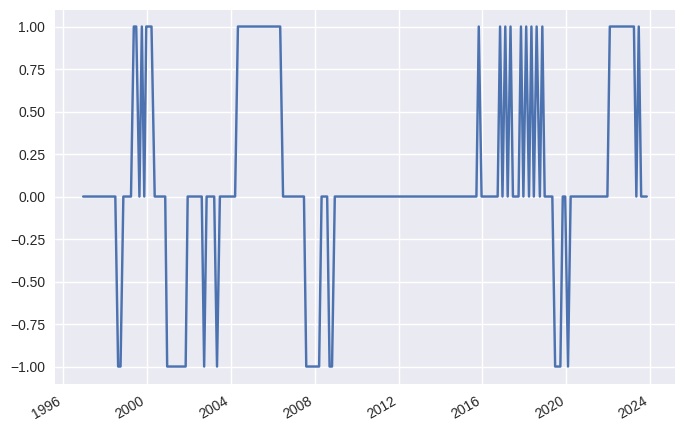

In [392]:
df["Decisión Política Monetaria"].plot()

In [393]:
df

,Fed Target Rate,Effective Fed Funds Rate,Decisión Política Monetaria,Tasa 3 Meses,Dovish,Hawkish,Neutral
1996-12-17,5.250,5.08,0,5.01,0.052162,0.368901,0.578937
1997-03-25,5.500,5.36,0,5.04,0.052382,0.572558,0.375059
1997-07-01,5.500,5.49,0,5.11,0.114263,0.215239,0.670498
1997-08-19,5.500,5.42,0,4.90,0.074832,0.390257,0.534911
1997-09-30,5.500,5.44,0,5.13,0.102670,0.523849,0.373481
...,...,...,...,...,...,...,...
2023-05-03,5.125,5.08,0,5.21,0.137240,0.373069,0.489690
2023-06-14,5.125,5.08,1,5.23,0.100451,0.410815,0.488733
2023-07-26,5.375,5.33,0,5.29,0.158601,0.479939,0.361460
2023-09-20,5.375,5.33,0,5.35,0.135375,0.452688,0.411937


## Division de los datos en diferentes dataset.

En esta parte del codigo dividimos los datos en tres conjuntos: entrenamiento, prueba y validación. Luego los balanceamos usando la función Smote. Esta práctica es fundamental para evaluar el rendimiento del modelo de manera justa y precisa, prevenir el sobreajuste y mejorar la capacidad de generalización del modelo. Al equilibrar los datos, evitamos sesgos y aumentamos la estabilidad y la robustez del modelo, lo que resulta en predicciones más confiables y precisas sobre la próxima decisión de la Reserva Federal respecto a la tasa de interés de referencia.


Para evaluar la importancia del análisis de sentimientos de las minutas en la predicción del comportamiento futuro de la Reserva Federal, creamos un conjunto de datos sin esta información. Esto nos permitió analizar cómo se comportan los modelos utilizando únicamente los datos relacionados con las tasas de interés, lo que nos brinda una visión más clara de la influencia específica de este factor en las predicciones de los modelos.

In [394]:
train_end_date = pd.Timestamp('2016-12-31')
val_start_date = pd.Timestamp('2016-01-01')
val_end_date = pd.Timestamp('2018-12-31')
train_set = df[df.index <= train_end_date]


###Train

In [395]:
X_train=train_set.drop(columns=['Decisión Política Monetaria'])
y_train1=train_set['Decisión Política Monetaria']
y_train_logistic=y_train1.astype(int)


### Validation

In [396]:
val_train_set = df[(df.index >= val_start_date) & (df.index <= val_end_date)]
X_val=val_train_set.drop(columns=['Decisión Política Monetaria'])
y_val1=val_train_set['Decisión Política Monetaria']
y_val=to_categorical(y_val1,num_classes=3)

### Test

In [397]:
test_set = df[df.index > val_end_date]
X_test=test_set.drop(columns=['Decisión Política Monetaria'])
y_test=test_set['Decisión Política Monetaria']
y_test1=test_set['Decisión Política Monetaria']
y_test=to_categorical(y_test1,num_classes=3)

### Balanceado (SMOTE)

In [398]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train1)

len(X_train_smote), len(y_train_smote)

(339, 339)

### Categorical

In [399]:
y_train=to_categorical(y_train_smote,num_classes=3)


###Data sin informacion de las minutas

In [400]:
X_train_sin_info_minuta=X_train_smote[['Fed Target Rate', 'Effective Fed Funds Rate', 'Tasa 3 Meses']]
X_test_sin_info_minuta=X_test[['Fed Target Rate', 'Effective Fed Funds Rate','Tasa 3 Meses']]
X_val_sin_info_minuta=X_val[['Fed Target Rate', 'Effective Fed Funds Rate', 'Tasa 3 Meses']]


Hemos desarrollado cuatro funciones para facilitar el análisis de los modelos. La primera función se llama "confusion_matrix_graph", que grafica una matriz de confusión para el modelo seleccionado. La segunda función, "metricas", visualiza la información de las métricas más importantes, incluyendo accuracy, f1 score, recall, precision, roc auc score y log loss. La tercera función, "metricas_comparacion", compara las métricas de un modelo con otro y las grafica. Por último, la cuarta función, "metricas_comparacion_1", muestra gráficamente las métricas de los cuatro modelos, permitiendo analizar su comportamiento con diferentes inputs. Estas funciones ayudarán a entender y comparar el rendimiento de los modelos de manera más efectiva.

In [401]:
def confusion_matrix_graph(y_test, y_pred):

  conf_matrix = confusion_matrix(y_test, y_pred)

  # Display the confusion matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
              xticklabels=['Class -1', 'Class 0', 'Class 1'],
              yticklabels=['Class -1', 'Class 0', 'Class 1'])
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.show()

In [402]:
def metricas(y, y_pred, y_proba):
    metrics_dict = {
        "accuracy": accuracy_score(y, y_pred),
        "f1": f1_score(y, y_pred, average='macro'),
        "recall": recall_score(y, y_pred, average='macro'),
        "precision": precision_score(y, y_pred, average='macro'),
        "roc_auc_score": roc_auc_score(y, y_proba, multi_class='ovo'),
        "log_loss": log_loss(y, y_proba)
    }

    metrics_series = pd.Series(metrics_dict)

    # # Plot bar graph
    plt.figure(figsize=(7, 7))
    ax = metrics_series.plot(kind='bar', colormap='viridis', edgecolor='white', alpha=0.7)

    plt.title('Classification Metrics by Class')
    plt.ylabel('Metric Value')
    plt.xlabel('Class')
    plt.xticks(rotation=0)

    plt.show()

    return metrics_series

In [403]:
def metricas_comparacion(y, y_pred_1, y_proba_1, y_pred_2, y_proba_2):
    metrics_dict_1 = {
        "accuracy": accuracy_score(y, y_pred_1),
        "f1": f1_score(y, y_pred_1, average='macro'),
        "recall": recall_score(y, y_pred_1, average='macro'),
        "precision": precision_score(y, y_pred_1, average='macro'),
        "roc_auc_score": roc_auc_score(to_categorical(y,num_classes=3), y_proba_1, multi_class='ovo'),
        "log_loss": log_loss(to_categorical(y,num_classes=3), y_proba_1)
    }
    metrics_dict_2 = {
        "accuracy": accuracy_score(y, y_pred_2),
        "f1": f1_score(y, y_pred_2, average='macro'),
        "recall": recall_score(y, y_pred_2, average='macro'),
        "precision": precision_score(y, y_pred_2, average='macro'),
        "roc_auc_score": roc_auc_score(to_categorical(y,num_classes=3), y_proba_2, multi_class='ovo'),
        "log_loss": log_loss(to_categorical(y,num_classes=3), y_proba_2)
    }
    metrics_series_1 = pd.Series(metrics_dict_1)
    metrics_series_2 = pd.Series(metrics_dict_2)
    df_final=pd.DataFrame({"modelos 1":metrics_series_1,
                           "Modelos 2":metrics_series_2})
        # Plotting both series on the same graph
    plt.plot(metrics_series_1, label='Modelo Sin Minutas', marker='o')
    plt.plot(metrics_series_2, label='Modelo con minutas', marker='o')
        # Adding labels and title
    plt.xlabel('Categories')
    plt.ylabel('Values')
    plt.title('Comparison of Metrics 1 and Metrics 2')

    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    # Display the plot
    plt.show()
    return df_final


In [404]:
def metricas_comparacion_1(y, y_pred_1, y_proba_1, y_pred_2, y_proba_2,y_pred_3, y_proba_3,y_pred_4, y_proba_4 ):



    metrics_dict_1 = {
        "accuracy": accuracy_score(y, y_pred_1),
        "f1": f1_score(y, y_pred_1, average='macro'),
        "recall": recall_score(y, y_pred_1, average='macro'),
        "precision": precision_score(y, y_pred_1, average='macro'),
        "roc_auc_score": roc_auc_score(to_categorical(y,num_classes=3), y_proba_1, multi_class='ovr'),
        "log_loss": log_loss(to_categorical(y,num_classes=3), y_proba_1)
    }

    metrics_dict_2 = {
            "accuracy": accuracy_score(y, y_pred_2),
            "f1": f1_score(y, y_pred_2, average='macro'),
            "recall": recall_score(y, y_pred_2, average='macro'),
            "precision": precision_score(y, y_pred_2, average='macro'),
            "roc_auc_score": roc_auc_score(to_categorical(y,num_classes=3), y_proba_2,multi_class='ovr'),
            "log_loss": log_loss(to_categorical(y,num_classes=3), y_proba_2)
        }
    metrics_dict_3 = {
            "accuracy": accuracy_score(y, y_pred_3),
            "f1": f1_score(y, y_pred_3, average='macro'),
            "recall": recall_score(y, y_pred_3, average='macro'),
            "precision": precision_score(y, y_pred_3, average='macro'),
            "roc_auc_score": roc_auc_score(to_categorical(y,num_classes=3), y_proba_3, multi_class='ovr'),
            "log_loss": log_loss(to_categorical(y,num_classes=3), y_proba_3)
      }

    metrics_dict_4 = {
            "accuracy": accuracy_score(y, y_pred_4),
            "f1": f1_score(y, y_pred_4, average='macro'),
            "recall": recall_score(y, y_pred_4, average='macro'),
            "precision": precision_score(y, y_pred_4, average='macro'),
            "roc_auc_score": roc_auc_score(to_categorical(y,num_classes=3), y_proba_4, multi_class='ovr'),
            "log_loss": log_loss(to_categorical(y,num_classes=3), y_proba_4)
      }






    metrics_series_1 = pd.Series(metrics_dict_1)
    metrics_series_2 = pd.Series(metrics_dict_2)
    metrics_series_3 = pd.Series(metrics_dict_3)
    metrics_series_4 = pd.Series(metrics_dict_4)
    df_final=pd.DataFrame({"Logistic sin Minutas":metrics_series_1,
                           "Logistic con Minutas":metrics_series_2,
                           "Red Neuronal sin Minutas":metrics_series_3,
                           "Red Neuronal con Minutas":metrics_series_4
                           })



        # Plotting both series on the same graph
    plt.plot(metrics_series_1, label='Logistic sin Minutas', marker='o')
    plt.plot(metrics_series_2, label='Logistic con Minutas', marker='o')
    plt.plot(metrics_series_3, label='Red Neuronal sin Minutas', marker='o')
    plt.plot(metrics_series_4, label='Red Neuronal con Minutas', marker='o')


        # Adding labels and title
    plt.xlabel('Categories')
    plt.ylabel('Values')
    plt.title('Comparación métricas de modelos')

    # Adding legend
    plt.legend()

    # Display the plot
    plt.show()
    return df_final


## Primer Modelo: Logistic Regression solamente con información de tasas

El primer modelo que desarrollamos es una regresión logística utilizando exclusivamente la información de tasas de interés. Se observa que este modelo es el peor de los cuatro, ya que todos sus indicadores son inferiores en comparación con los otros modelos. Esto sugiere que la información de tasas de interés usando este modelos, por sí sola puede no ser suficiente para realizar predicciones precisas sobre el comportamiento futuro de la Reserva Federal en relación con la tasa de interés de referencia.

##Gráfico 1

Matriz de confusión

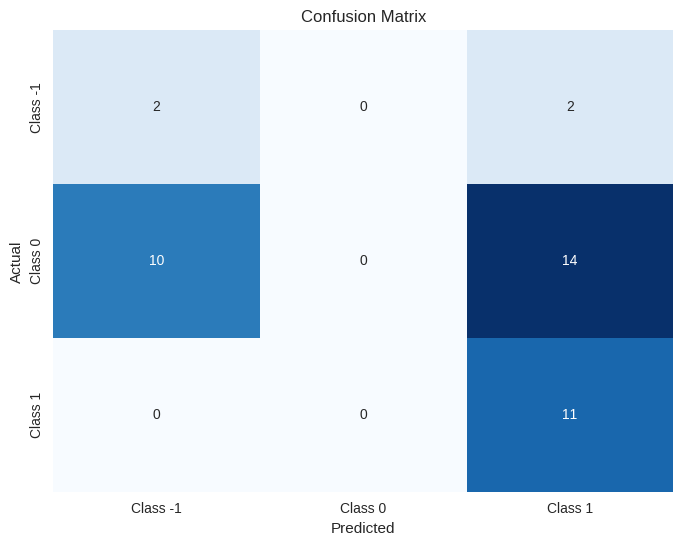

In [405]:
lr = LogisticRegression(random_state=42, class_weight='balanced', fit_intercept=False)
lr.fit(X_train_sin_info_minuta, y_train_smote)
y_pred_1 = lr.predict(X_test_sin_info_minuta)
y_prob_1=lr.predict_proba(X_test_sin_info_minuta)

confusion_matrix_graph(y_test1, y_pred_1)

##Gráfico 2
Gráficamos las principales métricas.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


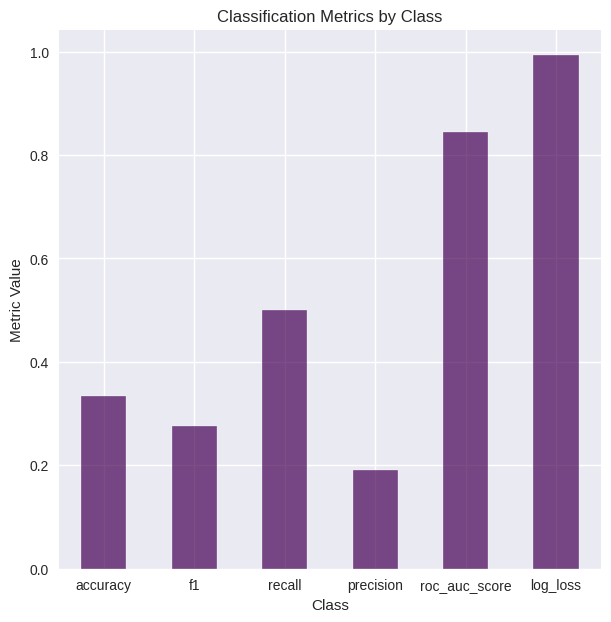

accuracy         0.333333
f1               0.276316
recall           0.500000
precision        0.191358
roc_auc_score    0.843908
log_loss         0.992709
dtype: float64

In [406]:
metricas(y_test1,y_pred_1,y_prob_1)

## Segundo Modelo: Logistic regression con informacion de tasas y con el análisis de las minutas

Al incluir la información proporcionada por las minutas, observamos una mejora significativa en el rendimiento del modelo para predecir las decisiones futuras de la Reserva Federal (ver gráfico 5). Esta disparidad entre los dos modelos resalta la importancia de las minutas en el proceso de predicción, demostrando cómo esta información adicional puede tener un impacto significativo en la capacidad predictiva del modelo.  

In [407]:
lr = LogisticRegression(random_state=42,fit_intercept=False)
lr.fit(X_train_smote, y_train_smote)
y_pred_2 = lr.predict(X_test)
y_prob_2=lr.predict_proba(X_test)

##Gráfico 3

Mátriz de confusión

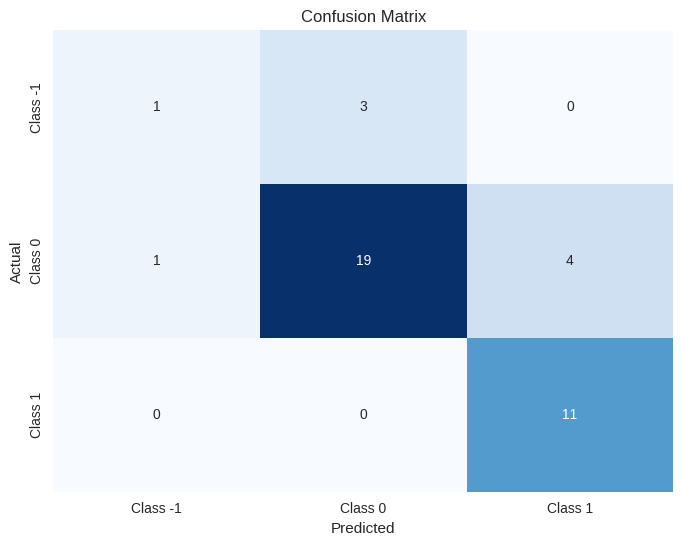

In [408]:
confusion_matrix_graph(y_test1, y_pred_2)

##Gráfico 4

Gráficamos las principales métricas.

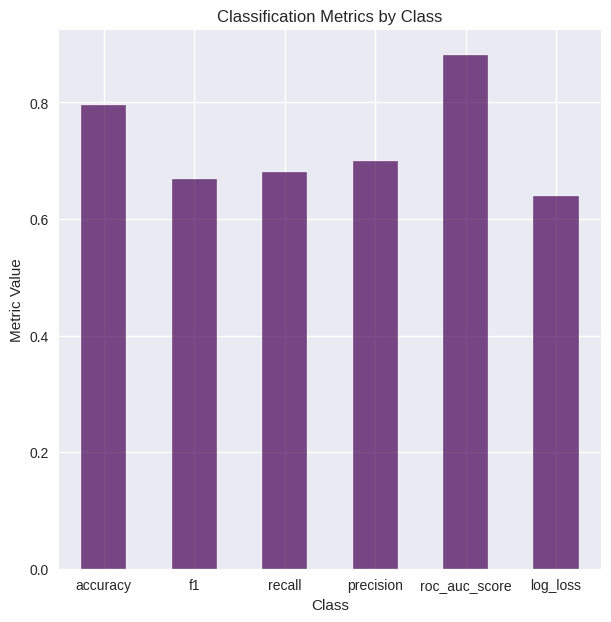

accuracy         0.794872
f1               0.668525
recall           0.680556
precision        0.698990
roc_auc_score    0.880682
log_loss         0.640125
dtype: float64

In [409]:
metricas(y_test1,y_pred_2,y_prob_2)


## Gráfico 5

Comparación de las métricas de los modelos de regresión lógistica.



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


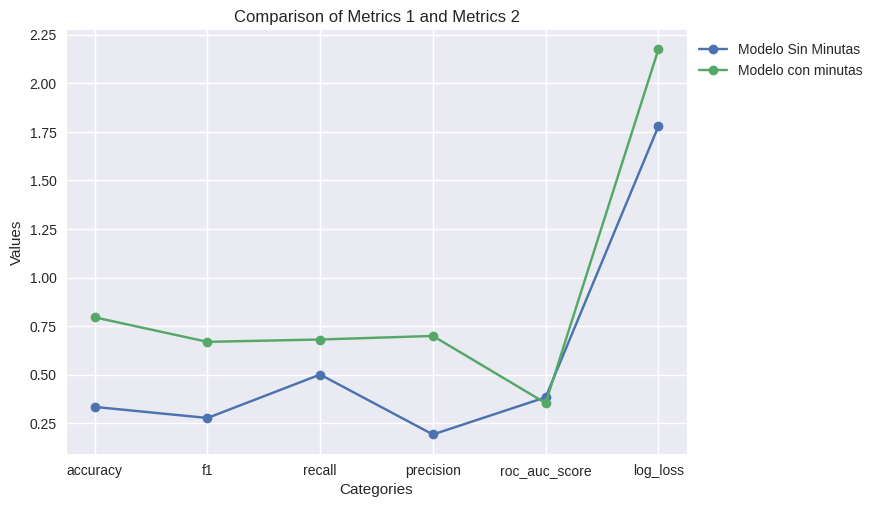

,modelos 1,Modelos 2
accuracy,0.333333,0.794872
f1,0.276316,0.668525
recall,0.500000,0.680556
precision,0.191358,0.698990
roc_auc_score,0.382912,0.353030
log_loss,1.778157,2.174715


In [410]:
metricas_comparacion(y_test1,y_pred_1,y_prob_1,y_pred_2,y_prob_2)

##Tercer Modelo: Redes Neuronales sin la informacion provista por las minutas

Este modelo utiliza redes neuronales y el conjunto de datos con el cual fue entrenado no contiene la información de las minutas. Se observa que este modelo es superior al modelo de regresión logística con el mismo conjunto de datos. Sin embargo, no supera al modelo de regresión logística que incorpora la información de las minutas. Esto sugiere que mientras las redes neuronales pueden mejorar el rendimiento en comparación con otros modelos como la regresión logística, la inclusión de información adicional, como las minutas, puede ser crucial para lograr predicciones aún más precisas.


In [411]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=3, activation='softmax')
])

In [412]:
patience=20
learning_rate=0.001
MAX_EPOCHS = 500
model=dense
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy',
                                                    patience=patience,
                                                      mode='min')

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train_sin_info_minuta, y_train, epochs=MAX_EPOCHS, validation_data=(X_val_sin_info_minuta,y_val),batch_size=30, callbacks=[early_stopping])

Epoch 1/500
12/12 [==============================] - 1s 20ms/step - loss: 1.1137 - accuracy: 0.4248 - val_loss: 1.1246 - val_accuracy: 0.0000e+00
Epoch 2/500
12/12 [==============================] - 0s 5ms/step - loss: 1.0489 - accuracy: 0.6224 - val_loss: 1.0834 - val_accuracy: 0.5417
Epoch 3/500
12/12 [==============================] - 0s 5ms/step - loss: 1.0176 - accuracy: 0.7109 - val_loss: 1.0763 - val_accuracy: 0.5833
Epoch 4/500
12/12 [==============================] - 0s 6ms/step - loss: 0.9887 - accuracy: 0.6814 - val_loss: 1.0468 - val_accuracy: 0.5833
Epoch 5/500
12/12 [==============================] - 0s 5ms/step - loss: 0.9606 - accuracy: 0.7198 - val_loss: 1.0106 - val_accuracy: 0.6667
Epoch 6/500
12/12 [==============================] - 0s 5ms/step - loss: 0.9371 - accuracy: 0.6903 - val_loss: 0.9859 - val_accuracy: 0.6667
Epoch 7/500
12/12 [==============================] - 0s 5ms/step - loss: 0.9051 - accuracy: 0.7434 - val_loss: 0.9424 - val_accuracy: 0.6667
Epoch 8/

In [413]:
predicted_classes=model.predict(X_test_sin_info_minuta)

2/2 [==============================] - 0s 4ms/step


In [414]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions
predictions_1 = model.predict(X_test_sin_info_minuta)
predicted_classes_1 = np.argmax(predictions_1, axis=1)
predicted_classes_1=np.where(predicted_classes_1 == 2, -1, np.where(predicted_classes_1 ==1, 1, 0))

predicted_classes_1


2/2 [==============================] - 0s 6ms/step


array([ 1,  1,  1, -1,  1, -1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1])

## Gráfico 6

Matriz de Confusión

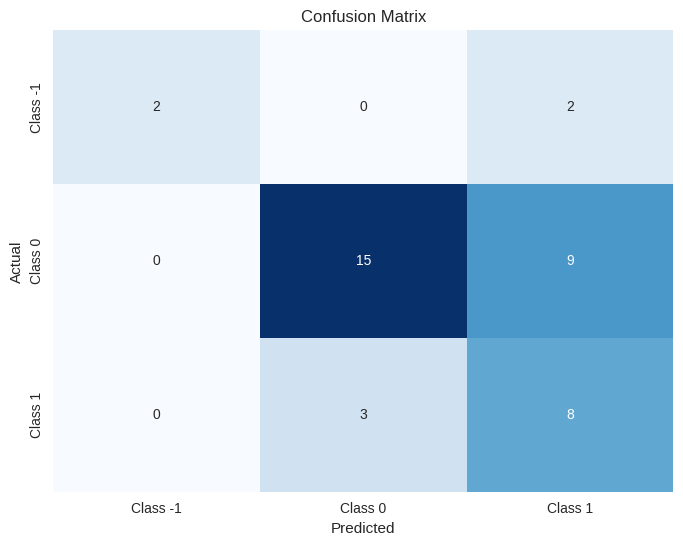

In [415]:
confusion_matrix_graph(y_test1, predicted_classes_1)


## Gráfico 6

Gráficamos las principales métricas.

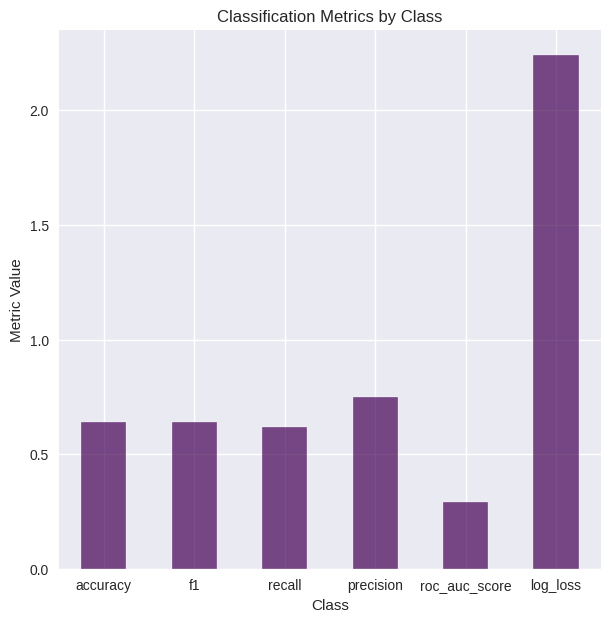

accuracy         0.641026
f1               0.638095
recall           0.617424
precision        0.751462
roc_auc_score    0.290404
log_loss         2.239990
dtype: float64

In [416]:
metricas(y_test1,predicted_classes_1,predictions_1)

##Cuarto Modelo: Redes Neuronales con la informacion provista por las minutas


Al incorporar la información de las minutas, convertimos el modelo de redes neuronales en nuestro mejor modelo (Ver gráfico 10). La combinación de las minutas con las redes neuronales nos ofrece el mejor escenario para la predicción, lo que resalta la importancia de aprovechar tanto la información histórica de las tasas como los detalles proporcionados en las minutas para obtener predicciones más precisas sobre las decisiones futuras de la Reserva Federal.

In [417]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=3, activation='softmax')
])


In [418]:
### anlisis del error
len(X_train_smote), len(X_val), len(y_train), len(y_val)

(339, 24, 339, 24)

In [419]:
patience=20
learning_rate=0.001
MAX_EPOCHS = 500
model=dense

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy',
                                                    patience=patience,
                                                      mode='min')

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(X_train_smote, y_train, epochs=MAX_EPOCHS, validation_data=(X_val,y_val),batch_size=30, callbacks=[early_stopping])

Epoch 1/500
12/12 [==============================] - 1s 21ms/step - loss: 1.0684 - accuracy: 0.4690 - val_loss: 1.0757 - val_accuracy: 0.5417
Epoch 2/500
12/12 [==============================] - 0s 6ms/step - loss: 1.0090 - accuracy: 0.7375 - val_loss: 1.0273 - val_accuracy: 0.5417
Epoch 3/500
12/12 [==============================] - 0s 6ms/step - loss: 0.9610 - accuracy: 0.7670 - val_loss: 0.9564 - val_accuracy: 0.6250
Epoch 4/500
12/12 [==============================] - 0s 8ms/step - loss: 0.8999 - accuracy: 0.7434 - val_loss: 0.9126 - val_accuracy: 0.6250
Epoch 5/500
12/12 [==============================] - 0s 6ms/step - loss: 0.8359 - accuracy: 0.7906 - val_loss: 0.8844 - val_accuracy: 0.6250
Epoch 6/500
12/12 [==============================] - 0s 6ms/step - loss: 0.7690 - accuracy: 0.8171 - val_loss: 0.8503 - val_accuracy: 0.6250
Epoch 7/500
12/12 [==============================] - 0s 6ms/step - loss: 0.7140 - accuracy: 0.8201 - val_loss: 0.8319 - val_accuracy: 0.6250
Epoch 8/500


In [420]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

predictions_2 = model.predict(X_test)
predicted_classes_2 = np.argmax(predictions_2, axis=1)


2/2 [==============================] - 0s 4ms/step


## Gráfico 7

Matriz de confusión.

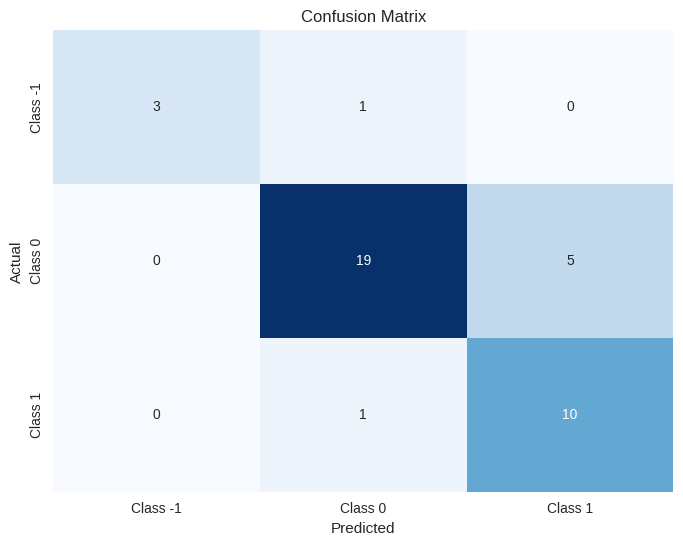

In [421]:
predicted_classes_2=np.where(predicted_classes_2 == 2, -1, np.where(predicted_classes_2 ==1, 1, 0))
confusion_matrix_graph(y_test1, predicted_classes_2)

## Gráfico 8

Gráficamos las principales métricas.

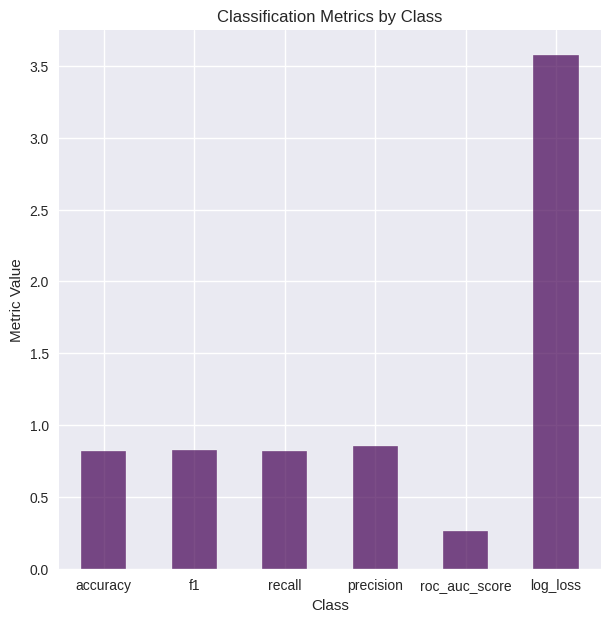

accuracy         0.820513
f1               0.823606
recall           0.816919
precision        0.857143
roc_auc_score    0.265941
log_loss         3.572653
dtype: float64

In [422]:

metricas(y_test1,predicted_classes_2,predictions_2)


## Gráfico 9

Comparación de las métricas de los modelos de redes neuronales.

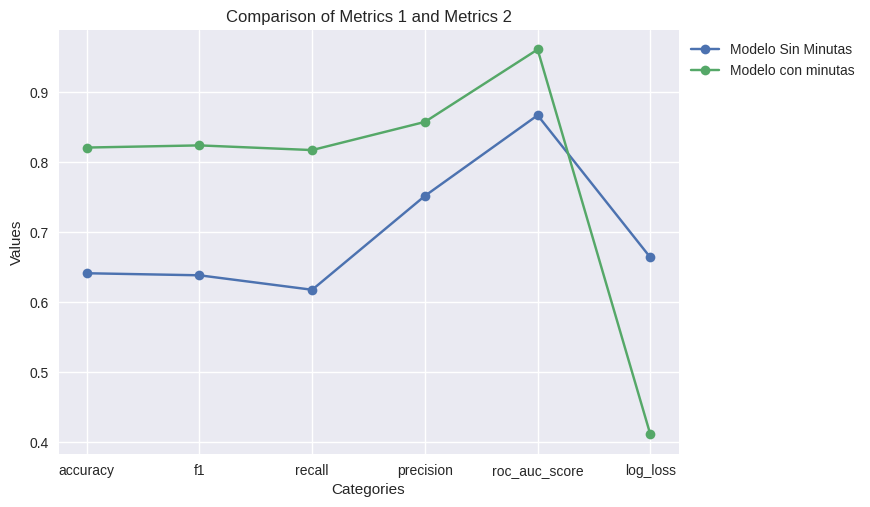

,modelos 1,Modelos 2
accuracy,0.641026,0.820513
f1,0.638095,0.823606
recall,0.617424,0.816919
precision,0.751462,0.857143
roc_auc_score,0.866643,0.960582
log_loss,0.663556,0.410781


In [423]:
metricas_comparacion(y_test1,predicted_classes_1,predictions_1,predicted_classes_2,predictions_2)

## Gráfico 10
Comparación de las métricas de los cuatro modelos.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


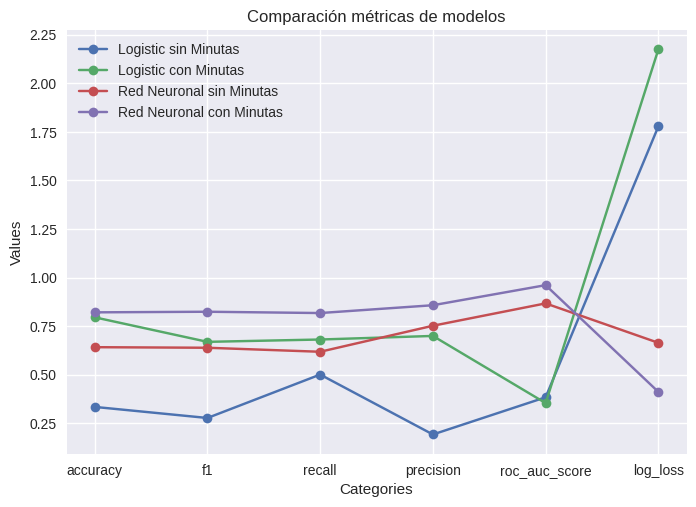

,Logistic sin Minutas,Logistic con Minutas,Red Neuronal sin Minutas,Red Neuronal con Minutas
accuracy,0.333333,0.794872,0.641026,0.820513
f1,0.276316,0.668525,0.638095,0.823606
recall,0.500000,0.680556,0.617424,0.816919
precision,0.191358,0.698990,0.751462,0.857143
roc_auc_score,0.382912,0.353030,0.866643,0.960582
log_loss,1.778157,2.174715,0.663556,0.410781


In [424]:
metricas_comparacion_1(y_test1,y_pred_1,y_prob_1,y_pred_2,y_prob_2, predicted_classes_1,predictions_1,predicted_classes_2,predictions_2)